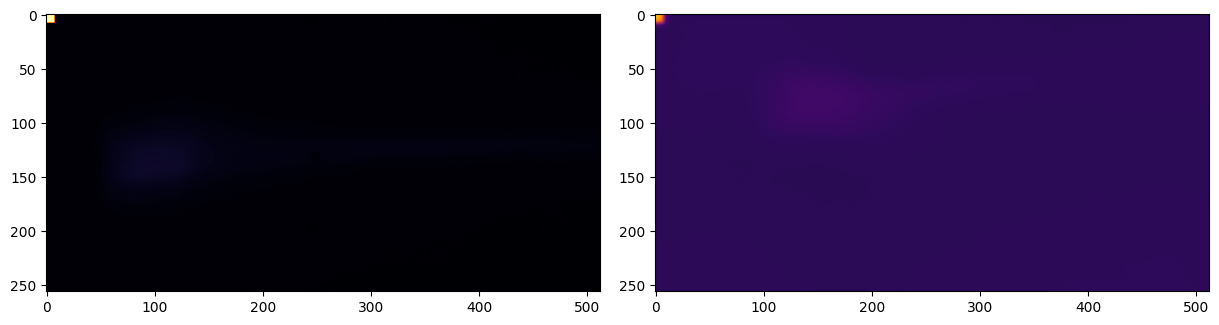

{'mse': tensor(6077.5381), 'mse_norm': tensor(0.0006), 'dtw_dist': 1594.645594982546, 'ssim': tensor(0.1608, dtype=torch.float64)}


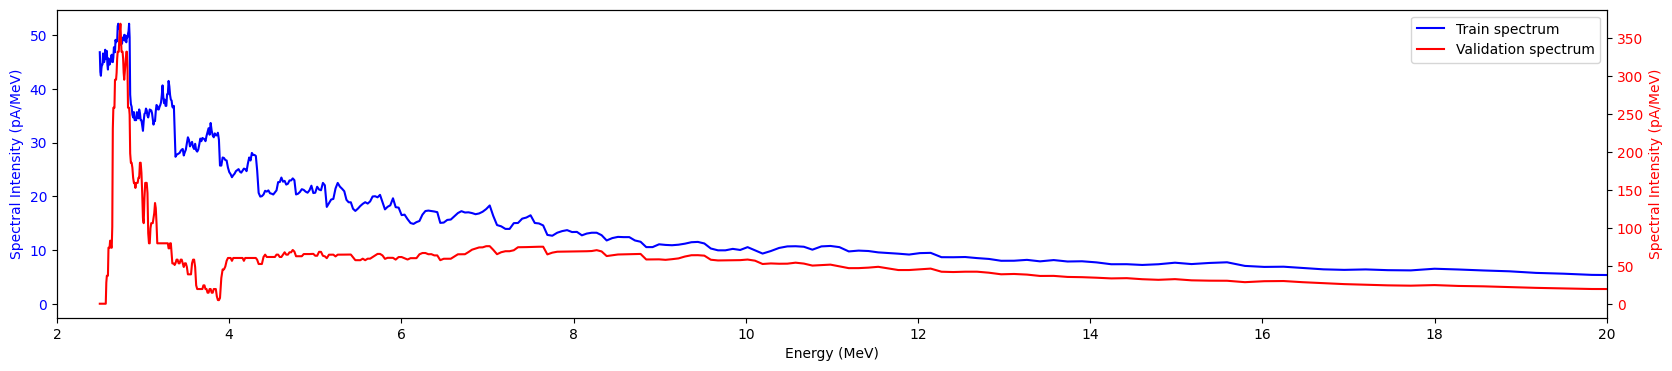

In [11]:
from metrics import *
import matplotlib.pyplot as plt
from src.utils import deflection_calc

def compare_avg_plot(im1, im2):
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    fig.subplots_adjust(hspace=0.35)  # Increase the space between rows
    fig.subplots_adjust(wspace=0.1)  # Decrease the space between columns
    # im2 *= 3
    # im2[:10, :10] = 255
    axs[0].imshow(im1, vmin=0, vmax=255, cmap='inferno')
    axs[1].imshow(im2, vmin=0, vmax=255, cmap='inferno')
    plt.show()

def plot_spectra(sp1, sp2, el_pointing_pixel=62, xlim=[2, 20]):
    fig, ax1 = plt.subplots(figsize=(20, 4))
    deflection_MeV = deflection_calc(1, len(sp1), el_pointing_pixel).flatten()
    
    # Plot the first sequence on the left y-axis
    ax1.plot(deflection_MeV, sp1, label='Train spectrum', color='blue')
    ax1.set_ylabel('Spectral Intensity (pA/MeV)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_xlabel('Energy (MeV)')
    ax1.set_xlim(xlim)
    
    # Create a second y-axis on the right side
    ax2 = ax1.twinx()
    
    # Plot the second sequence on the right y-axis
    ax2.plot(deflection_MeV, sp2, label='Validation spectrum', color='red')
    ax2.set_ylabel('Spectral Intensity (pA/MeV)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Add a legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')
    
    plt.show()

# 3, 8, 11, 19, 21
dirnum = 19

dir1 = 'data/with_gain/' + str(dirnum)
# dir2 = 'results/valid_nophys_1000ns_sec25_cfg3/' + str(dirnum)
dir2 = 'results/valid_phys10th_850ns_sec1x9plus6_cfg5/' + str(dirnum)

res, spectra = compare_spectra(dir1, dir2, dirnum)
img1, img2 = compare_avg(dir1, dir2)
compare_avg_plot(img1, img2)
print(res)
plot_spectra(spectra['spectr_train'], spectra['spectr_valid'])

In [13]:
import pandas as pd


# Load the CSV file
file_path = 'metrics.csv'
df = pd.read_csv(file_path)

df.head()

# Process the first column to extract the required information
def extract_details(row):
    # Removing 'valid_' prefix and splitting the string
    parts = row.replace('valid_', '').split('_')

    # Extracting model type
    if 'nophys' in parts:
        model_type = 'nophys'
    elif 'phys10th' in parts and 'beam' not in parts:
        model_type = 'phys10th'
    else:
        model_type = 'phys10thbeam'

    # Extracting noise steps
    noise_steps = next((part for part in parts if part.endswith('ns')), None)

    # Extracting sections
    sections = next((part for part in parts if 'sec' in part), None)

    # Extracting CFG
    cfg = next((part for part in parts if part.startswith('cfg')), None)

    return model_type, noise_steps, sections, cfg

# Apply the function to the dataframe
df[['Model Type', 'Noise Steps', 'Sections', 'CFG']] = df.apply(lambda row: extract_details(row.iloc[0]), axis=1, result_type='expand')

# Rename the first column to remove 'valid_'
df.rename(columns={df.columns[0]: 'Description'}, inplace=True)
# Rename the numbers column to 'FID' and move it to the end
df.rename(columns={df.columns[1]: 'FID'}, inplace=True)

# Rearranging columns to move 'FID' to the end
column_order = ['Model Type', 'Noise Steps', 'Sections', 'CFG', 'FID']
df = df[column_order]

# Remove the 'Description' column
df.drop(columns=['Description'], inplace=True, errors='ignore')
# Extracting only the number from the 'CFG' column
df['CFG'] = df['CFG'].str.extract('(\d+)').astype(int)

# Function to transform the 'Sections' values
def transform_section(value):
    if value == 'sec1x9plus6':
        return '9+6'
    elif value == 'sec2x9plus7':
        return '18+7'
    else:
        # Extract only the number for other 'sec' values
        return ''.join(filter(str.isdigit, value))

# Apply the transformation to the 'Sections' column
df['Sections'] = df['Sections'].apply(transform_section)

df.head()
df.to_csv('results.csv')


In [1]:
import os
import pandas as pd
from metrics import *
from tqdm import tqdm

import os
import pandas as pd

def process_folder_results(results_dir):
    all_results = []

    # Loop through each main subfolder in results
    for main_folder_name in tqdm(os.listdir(results_dir)):
        main_folder_path = os.path.join(results_dir, main_folder_name)

        if not os.path.isdir(main_folder_path):
            print()
            continue

        # Initialize accumulators for metrics
        total_metrics = {'MSE': 0, 'MSE_Norm': 0, 'Var_Diff': 0}
        num_experiments = 0

        # Loop through each experiment number subfolder
        for exp_folder_name in os.listdir(main_folder_path):
            exp_folder_path = os.path.join(main_folder_path, exp_folder_name)
            if not os.path.isdir(exp_folder_path):
                continue

            exp_num = int(exp_folder_name)
            train_folder = os.path.join("data/with_gain", str(exp_num))

            # Call compare_spectra function
            res, _ = compare_spectra(train_folder, exp_folder_path, exp_num)

            # Accumulate the results (convert tensors to floats)
            total_metrics['MSE'] += res['mse'].item() if isinstance(res['mse'], torch.Tensor) else res['mse']
            total_metrics['MSE_Norm'] += res['mse_norm'].item() if isinstance(res['mse_norm'], torch.Tensor) else res['mse_norm']
            total_metrics['Var_Diff'] += res['var_diff']
            num_experiments += 1

        # Calculate averages
        for key in total_metrics.keys():
            total_metrics[key] /= num_experiments

        # Extract parameters from main folder name
        main_folder_name = main_folder_name.replace('_beam', 'beam')
        parts = main_folder_name.replace('valid_', '').split('_')
        model_type = parts[0]
        noise_steps = int(parts[1].replace('ns', ''))
        sections = parts[2].replace('sec1x9plus6', '9+6').replace('sec2x9plus7', '18+7').replace('sec', '')
        cfg = int(parts[3].replace('cfg', ''))

        # Append averaged results and parameters to the list
        all_results.append({
            'Model Type': model_type,
            'Noise Steps': noise_steps,
            'Sections': sections,
            'CFG': cfg,
            **total_metrics
        })

    # Create a DataFrame and save to CSV
    results_df = pd.DataFrame(all_results)
    results_df.to_csv('results_analysis.csv', index=False)

# Replace 'path_to_results_folder' with the actual path to your results folder
process_folder_results('results')



/home/jechmate/anaconda3/envs/eli/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 225/225 [05:44<00:00,  1.53s/it]


## START HERE

In [2]:
import pandas as pd

# Load the two CSV files
file_path_results = 'results.csv'  # Replace with your actual file path
file_path_analysis = 'results_analysis.csv'  # Replace with your actual file path

df_results = pd.read_csv(file_path_results)
df_analysis = pd.read_csv(file_path_analysis)

# Convert 'Noise Steps' in df_results to int64 (if necessary)
df_results['Noise Steps'] = df_results['Noise Steps'].str.replace('ns', '').astype(int)

# Merge the dataframes
# Ensure that the columns used for merging have the same name and data type in both dataframes
df_combined = pd.merge(df_results, df_analysis, on=['Model Type', 'Noise Steps', 'Sections', 'CFG'], how='left')

# Save the merged dataframe (optional)
df_combined.to_csv('combined.csv', index=False)  # Replace with your desired file path


In [17]:
import pandas as pd

# Load your combined dataframe
df_combined = pd.read_csv('combined.csv')

# List of metrics
metrics = ['FID', 'MSE', 'MSE_Norm', 'Var_Diff']
# metrics = ['FID']
# metrics = ['Var_Diff']
# metrics = ['MSE_Norm', 'Var_Diff']
# metrics = ['MSE']
# metrics = ['MSE', 'MSE_Norm']

# Calculate ranks for each metric and average rank
for metric in metrics:
    df_combined[f'Rank_{metric}'] = df_combined[metric].rank()
df_combined['Average Rank'] = df_combined[[f'Rank_{metric}' for metric in metrics]].mean(axis=1)

# Find the top k models based on the average rank
k = 5
top_models_avg_rank = df_combined.nsmallest(k, 'Average Rank')

# Print the top k models
print(top_models_avg_rank[['Model Type', 'Noise Steps', 'Sections', 'CFG', 'FID', 'MSE', 'MSE_Norm', 'Var_Diff', 'Average Rank']])


         Model Type  Noise Steps Sections  CFG         FID          MSE  \
215  phys_spec_beam          850     18+7    1  105.376659  7100.061290   
170  phys_spec_beam         1000       45    1  112.141104  9567.288885   
195  phys_spec_beam          700       45    1  113.631022  7145.196639   
185  phys_spec_beam          700       25    1  113.081286  5396.396002   
190  phys_spec_beam          700     18+7    1  106.214213  9408.847206   

     MSE_Norm   Var_Diff  Average Rank  
215  0.000035  59.837664         31.75  
170  0.000032  53.797889         34.25  
195  0.000032  58.061960         34.75  
185  0.000035  59.477565         35.75  
190  0.000030  63.965196         36.00  


Unnamed: 0         int64
Model Type        object
Noise Steps        int64
Sections          object
CFG                int64
FID              float64
MSE              float64
MSE_Norm         float64
Var_Diff         float64
Rank_FID         float64
Rank_MSE         float64
Rank_MSE_Norm    float64
Rank_Var_Diff    float64
Average Rank     float64
dtype: object


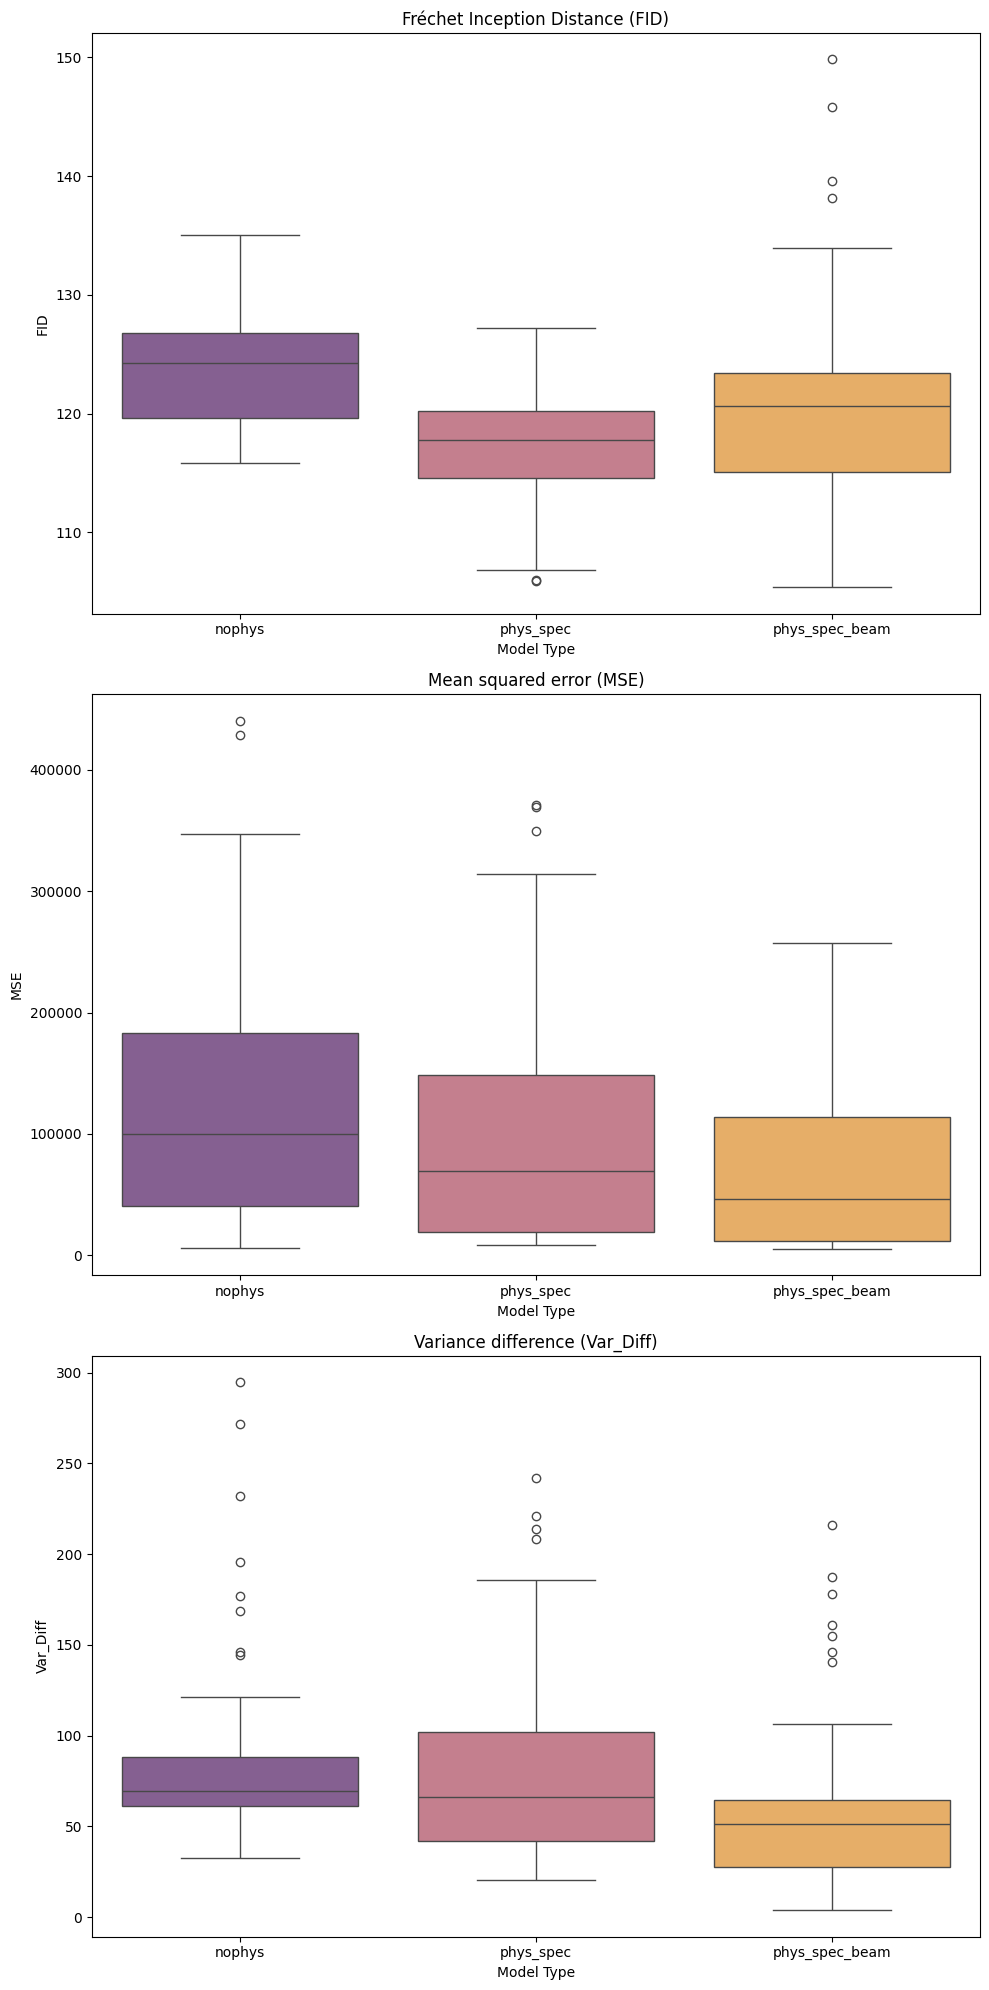

10:17:13 - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_2923861/411682247.py:35: UserWarning: 
The palette list has fewer values (3) than needed (5) and will cycle, which may produce an uninterpretable plot.
  box_plot = sns.boxplot(x='CFG', y=metric, data=df_combined, palette=pastel_palette, hue='CFG', legend=False)
10:17:13 - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
10:17:13 - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_2923861/411682247.py:35: UserWarning: 
The palette list has fewer values (3) than need

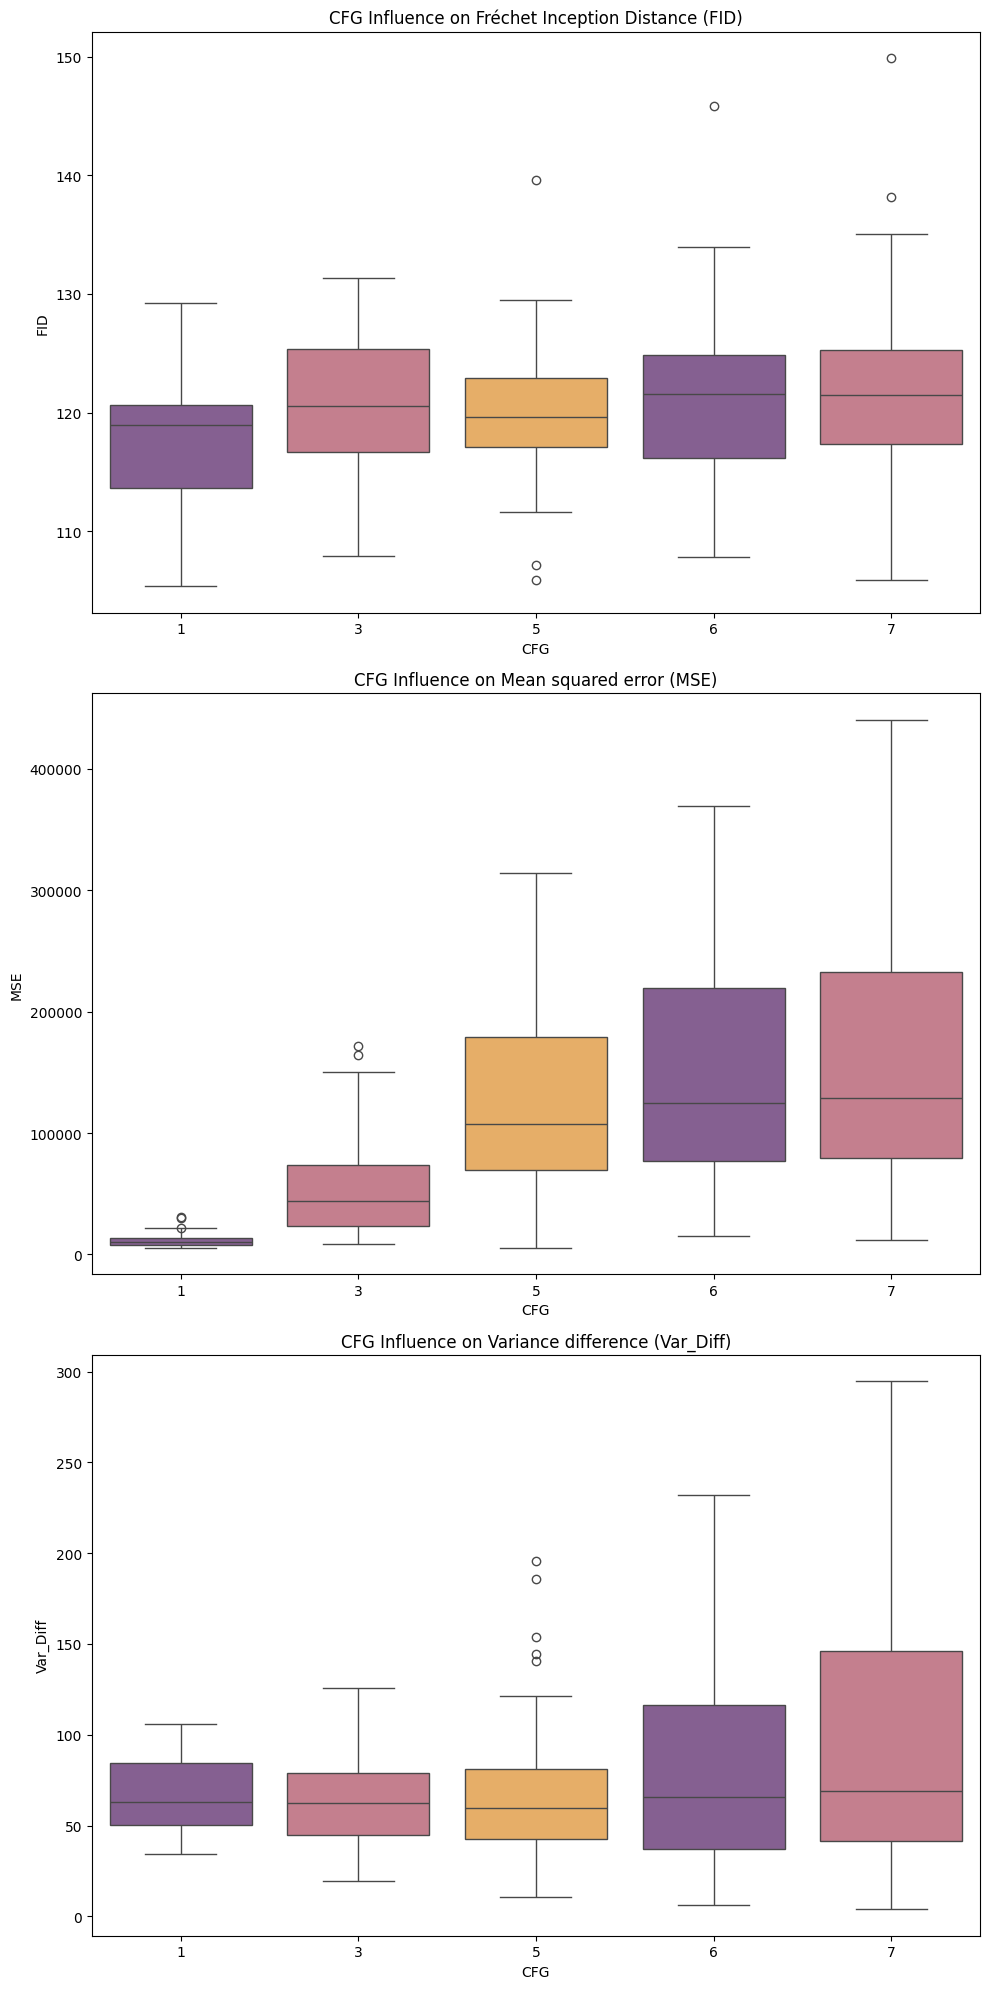

/tmp/ipykernel_2923861/411682247.py:45: UserWarning: 
The palette list has fewer values (3) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x='Sections', y=metric, data=df_combined, palette=pastel_palette, hue='Sections', legend=False)
/tmp/ipykernel_2923861/411682247.py:45: UserWarning: 
The palette list has fewer values (3) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x='Sections', y=metric, data=df_combined, palette=pastel_palette, hue='Sections', legend=False)
/tmp/ipykernel_2923861/411682247.py:45: UserWarning: 
The palette list has fewer values (3) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x='Sections', y=metric, data=df_combined, palette=pastel_palette, hue='Sections', legend=False)


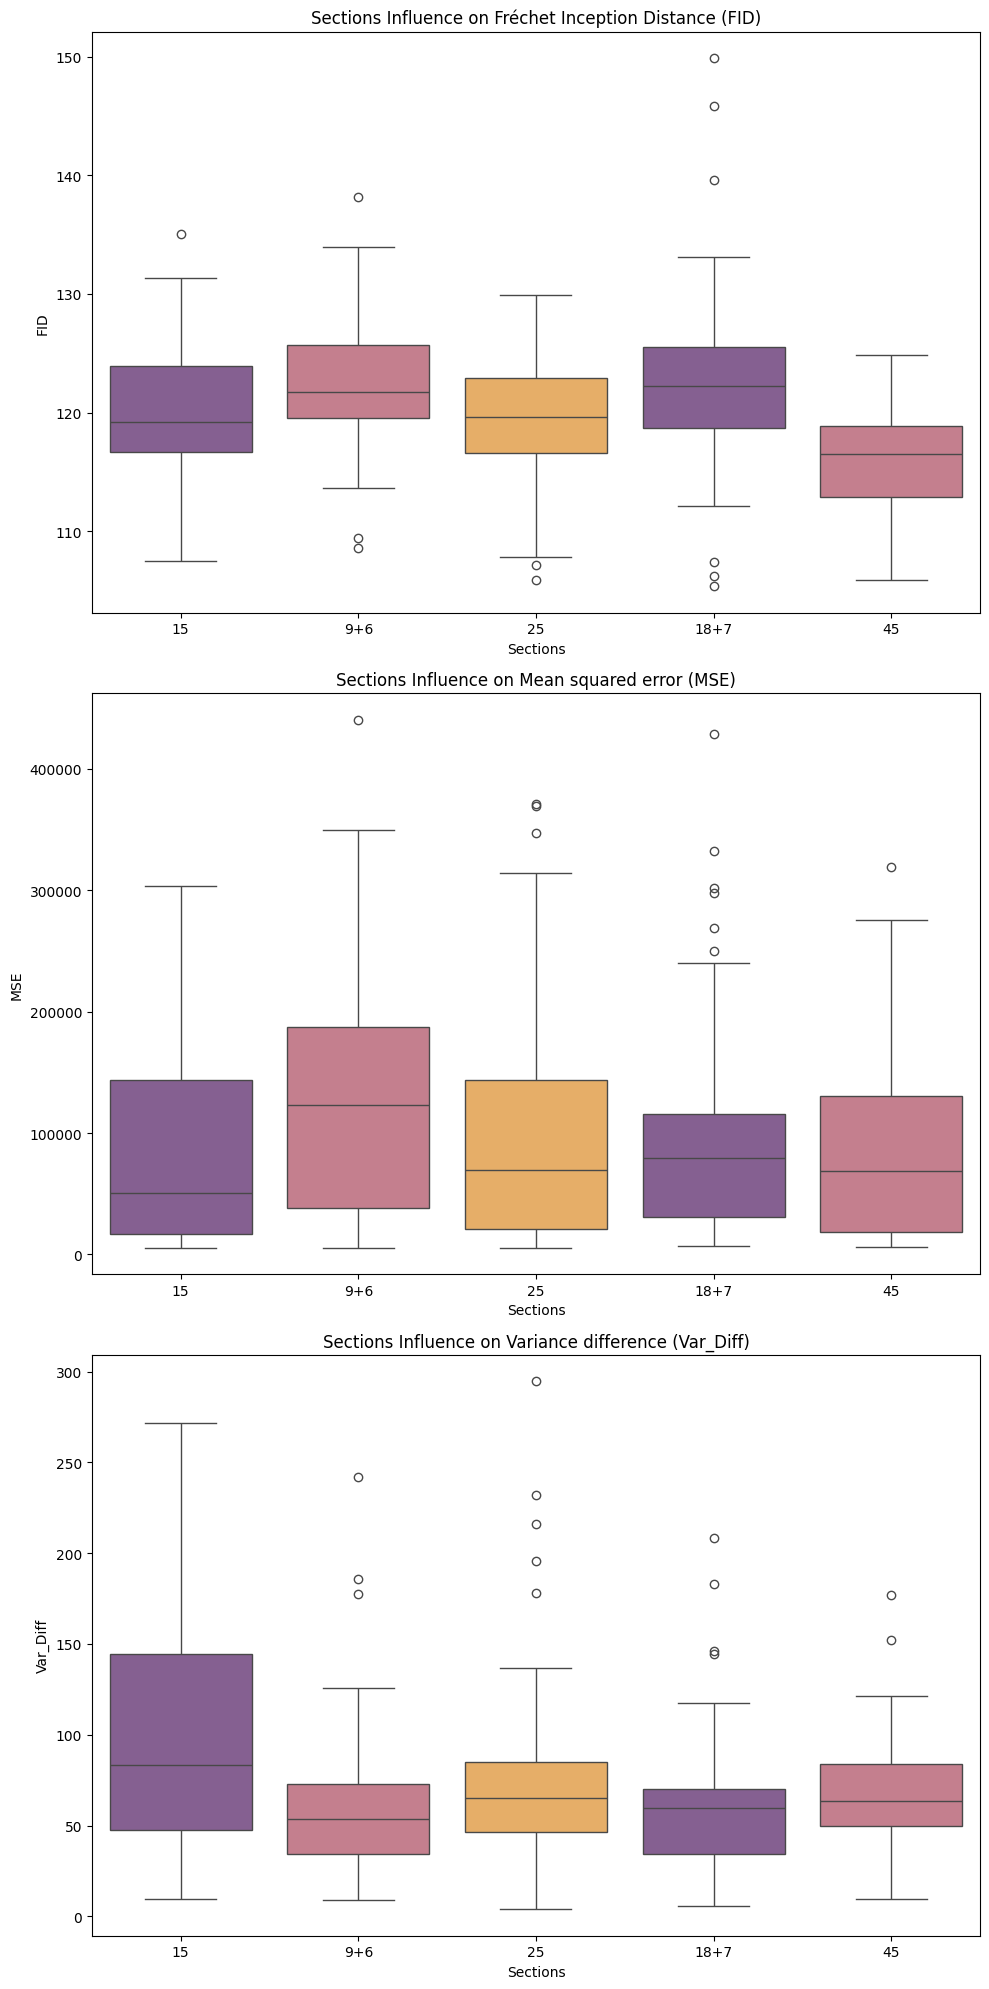

10:17:14 - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
10:17:14 - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
10:17:14 - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
10:17:14 - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
10:17:14 - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appr

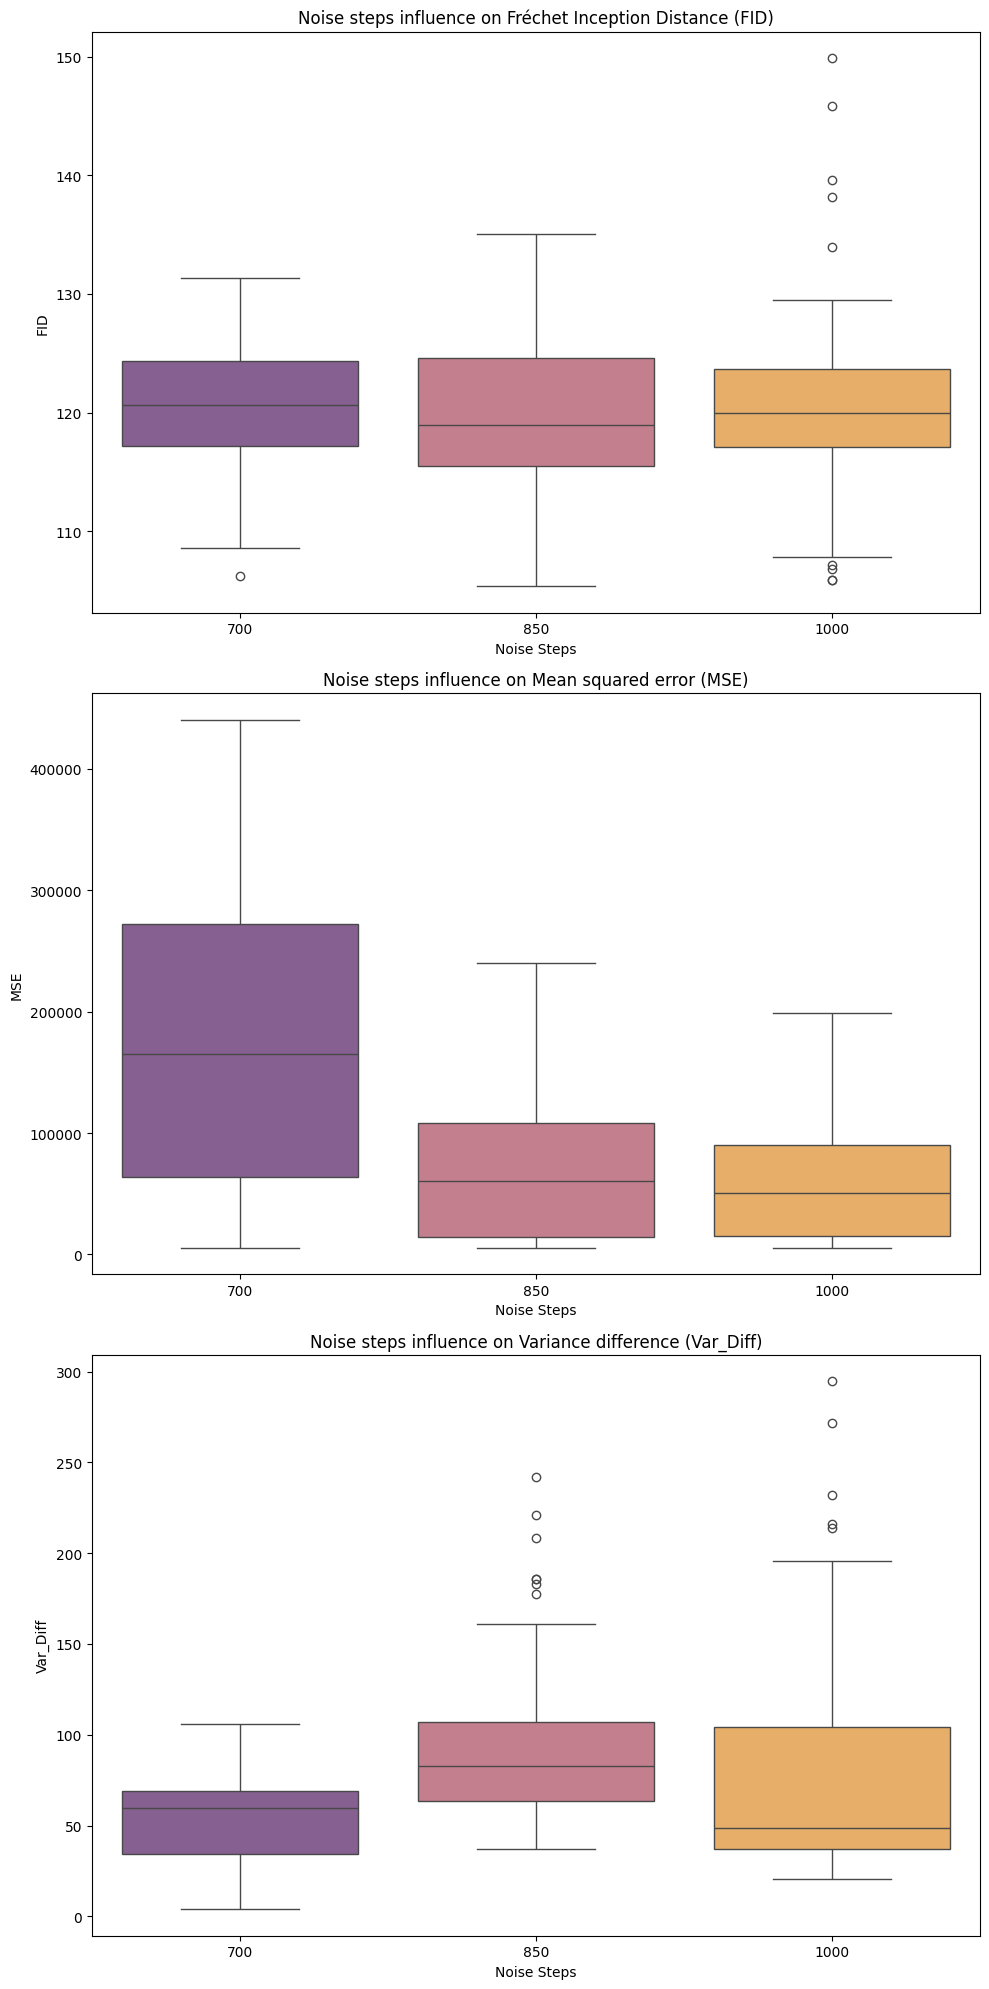

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from metrics import *

def to_pastel(color, weight=0.3):
    """ Blend color with white to create a pastel shade """
    white = np.array([1, 1, 1])
    color = np.array(color)
    return list((1 - weight) * color + weight * white)

# Adjusting color palette for distinct model types
metrics = ['FID', 'MSE', 'Var_Diff']
original_palette = sns.color_palette('inferno', n_colors=len(df_combined['Model Type'].unique()))
pastel_palette = [to_pastel(color) for color in original_palette]
titles = ['Fréchet Inception Distance (FID)', 'Mean squared error (MSE)', 'Variance difference (Var_Diff)']


print(df_combined.dtypes)
# Creating plots for FID, MSE, MSE_Norm, and Var_Diff with distinct colors
plt.figure(figsize=(10, 20))
for i, metric in enumerate(metrics):
    plt.subplot(len(metrics), 1, i+1)
    sns.boxplot(x='Model Type', y=metric, data=df_combined, palette=pastel_palette, hue='Model Type')
    plt.title(titles[i])

plt.tight_layout()
plt.show()

# Creating plots comparing the influence of CFG and Sections (sec) on the different metrics
# CFG influence
plt.figure(figsize=(10, 20))
for i, metric in enumerate(metrics):
    plt.subplot(len(metrics), 1, i+1)
    box_plot = sns.boxplot(x='CFG', y=metric, data=df_combined, palette=pastel_palette, hue='CFG', legend=False)
    plt.title(f'CFG Influence on {titles[i]}')

plt.tight_layout()
plt.show()

# Sections influence
plt.figure(figsize=(10, 20))
for i, metric in enumerate(metrics):
    plt.subplot(len(metrics), 1, i+1)
    sns.boxplot(x='Sections', y=metric, data=df_combined, palette=pastel_palette, hue='Sections', legend=False)
    plt.title(f'Sections Influence on {titles[i]}')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 20))
for i, metric in enumerate(metrics):
    plt.subplot(len(metrics), 1, i+1)
    sns.boxplot(x='Noise Steps', y=metric, data=df_combined, palette=pastel_palette, hue='Noise Steps', legend=False)
    plt.title(f'Noise steps influence on {titles[i]}')

plt.tight_layout()
plt.show()


In [38]:
median = df_combined.groupby(['Sections', 'Model Type'])['Var_Diff'].median()
var = df_combined.groupby(['Sections', 'Model Type'])['Var_Diff'].var()

print(median)
print(var)

Sections  Model Type    
15        nophys            78.041923
          phys_spec         96.998744
          phys_spec_beam    64.405023
18+7      nophys            62.932719
          phys_spec         70.263410
          phys_spec_beam    43.312299
25        nophys            76.267794
          phys_spec         65.643661
          phys_spec_beam    51.425156
45        nophys            78.830177
          phys_spec         55.453660
          phys_spec_beam    53.542898
9+6       nophys            60.266710
          phys_spec         56.159075
          phys_spec_beam    45.200768
Name: Var_Diff, dtype: float64
Sections  Model Type    
15        nophys            3464.703880
          phys_spec         4207.261448
          phys_spec_beam    3554.140822
18+7      nophys             773.913230
          phys_spec         3374.559648
          phys_spec_beam     422.908783
25        nophys            5364.607871
          phys_spec         1123.318405
          phys_spec_beam    3

1
2
3


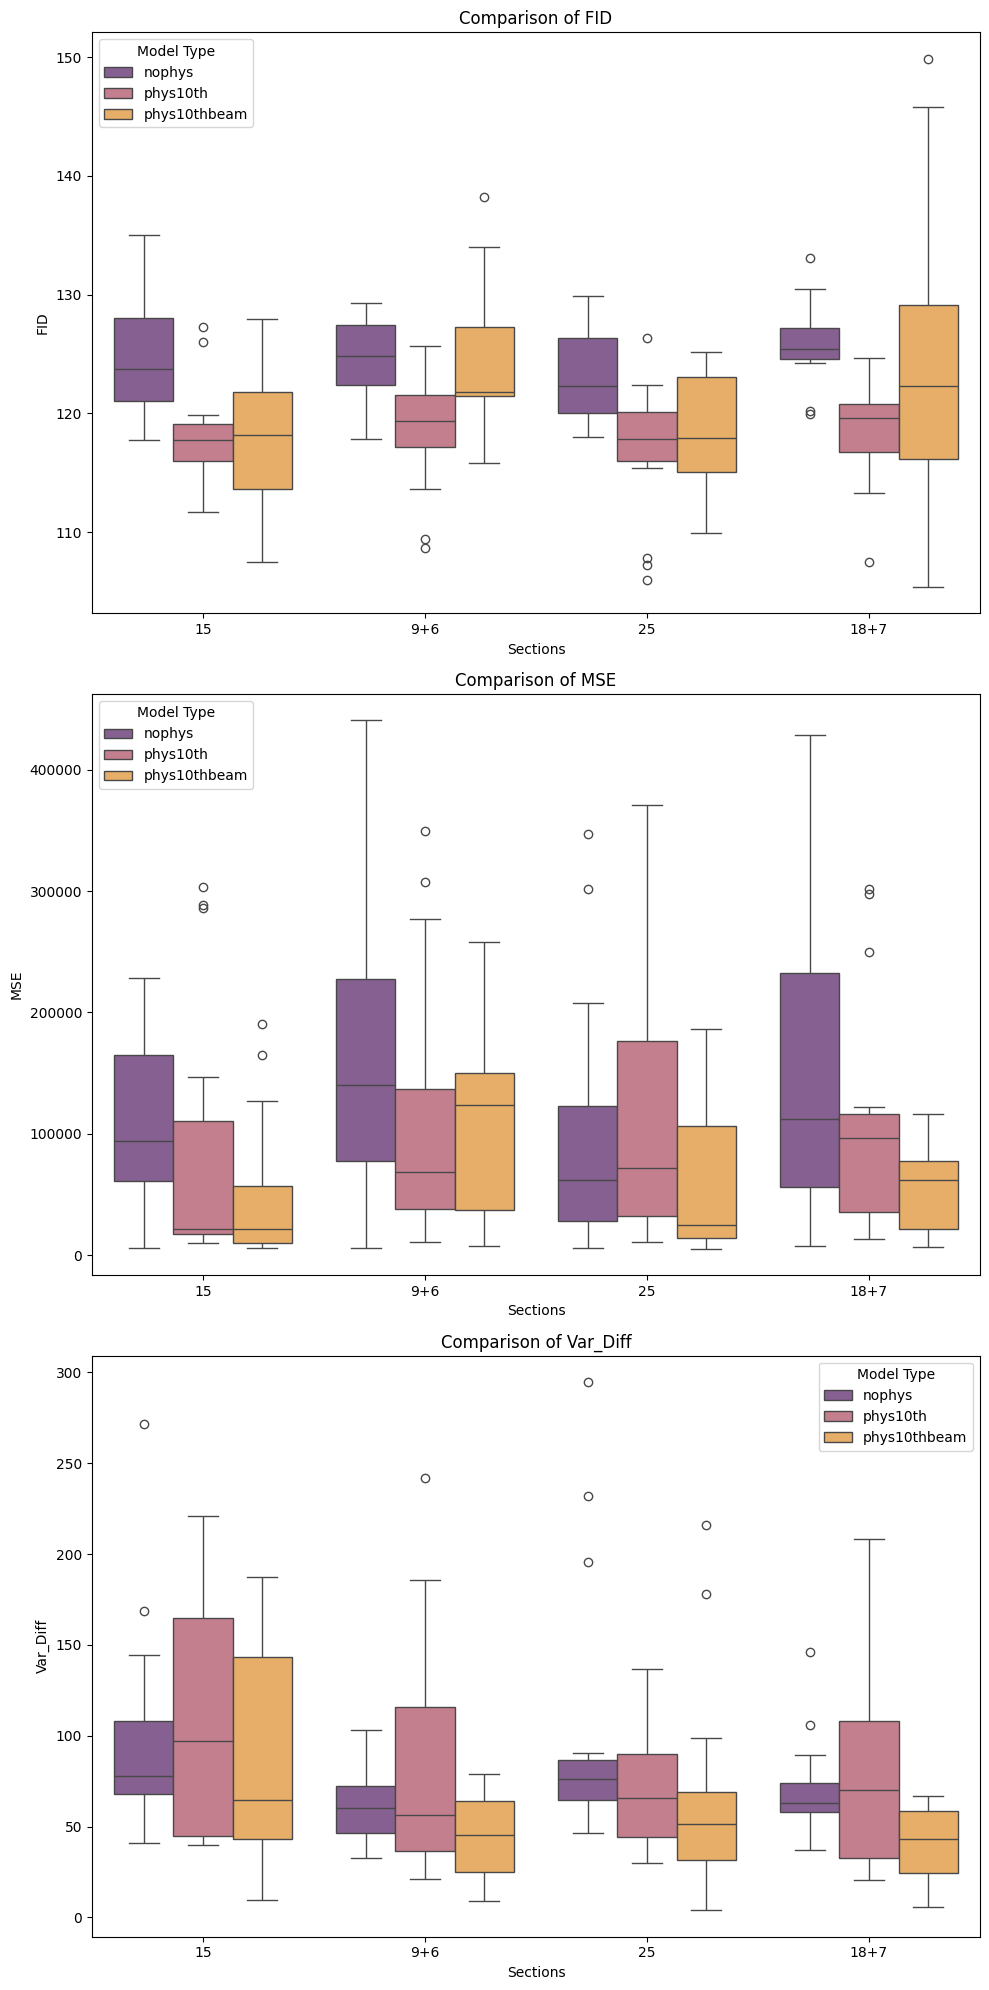

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Preparing data for the specified comparisons
# Combining sections as per the user's request
data = pd.read_csv('combined.csv')
# data['Combined Sections'] = data['Sections'].replace({'9': '9+6', '6': '9+6', '18': '18+7', '7': '18+7'})

# Filtering data for the required comparisons
comparison_groups = ['9+6', '15', '18+7', '25']
filtered_data = data[data['Sections'].isin(comparison_groups)]

def to_pastel(color, weight=0.3):
    """ Blend color with white to create a pastel shade """
    white = np.array([1, 1, 1])
    color = np.array(color)
    return list((1 - weight) * color + weight * white)

# Adjusting color palette for distinct model types
metrics = ['FID', 'MSE', 'Var_Diff']
original_palette = sns.color_palette('inferno', n_colors=3)
pastel_palette = [to_pastel(color) for color in original_palette]

# Plotting box charts for each metric
plt.figure(figsize=(10, 20))

for i, metric in enumerate(metrics, 1):
    print(i)
    plt.subplot(len(metrics), 1, i)
    sns.boxplot(x='Sections', y=metric, hue='Model Type', data=filtered_data, palette=pastel_palette)
    plt.title(f'Comparison of {metric}')
    plt.xlabel('Sections')
    plt.ylabel(metric)
    plt.legend(title='Model Type')

plt.tight_layout()
plt.show()


In [5]:
import pandas as pd

# Assuming 'data' is your DataFrame and it's already loaded
# Replace 'path_to_your_file.csv' with your actual file path
data = pd.read_csv('combined.csv')

# Renaming model types
data['Model Type'] = data['Model Type'].replace({'phys10th': 'phys_spec', 'phys10thbeam': 'phys_spec_beam'})

# If you want to save the modified DataFrame to a new file
data.to_csv('combined.csv', index=False)


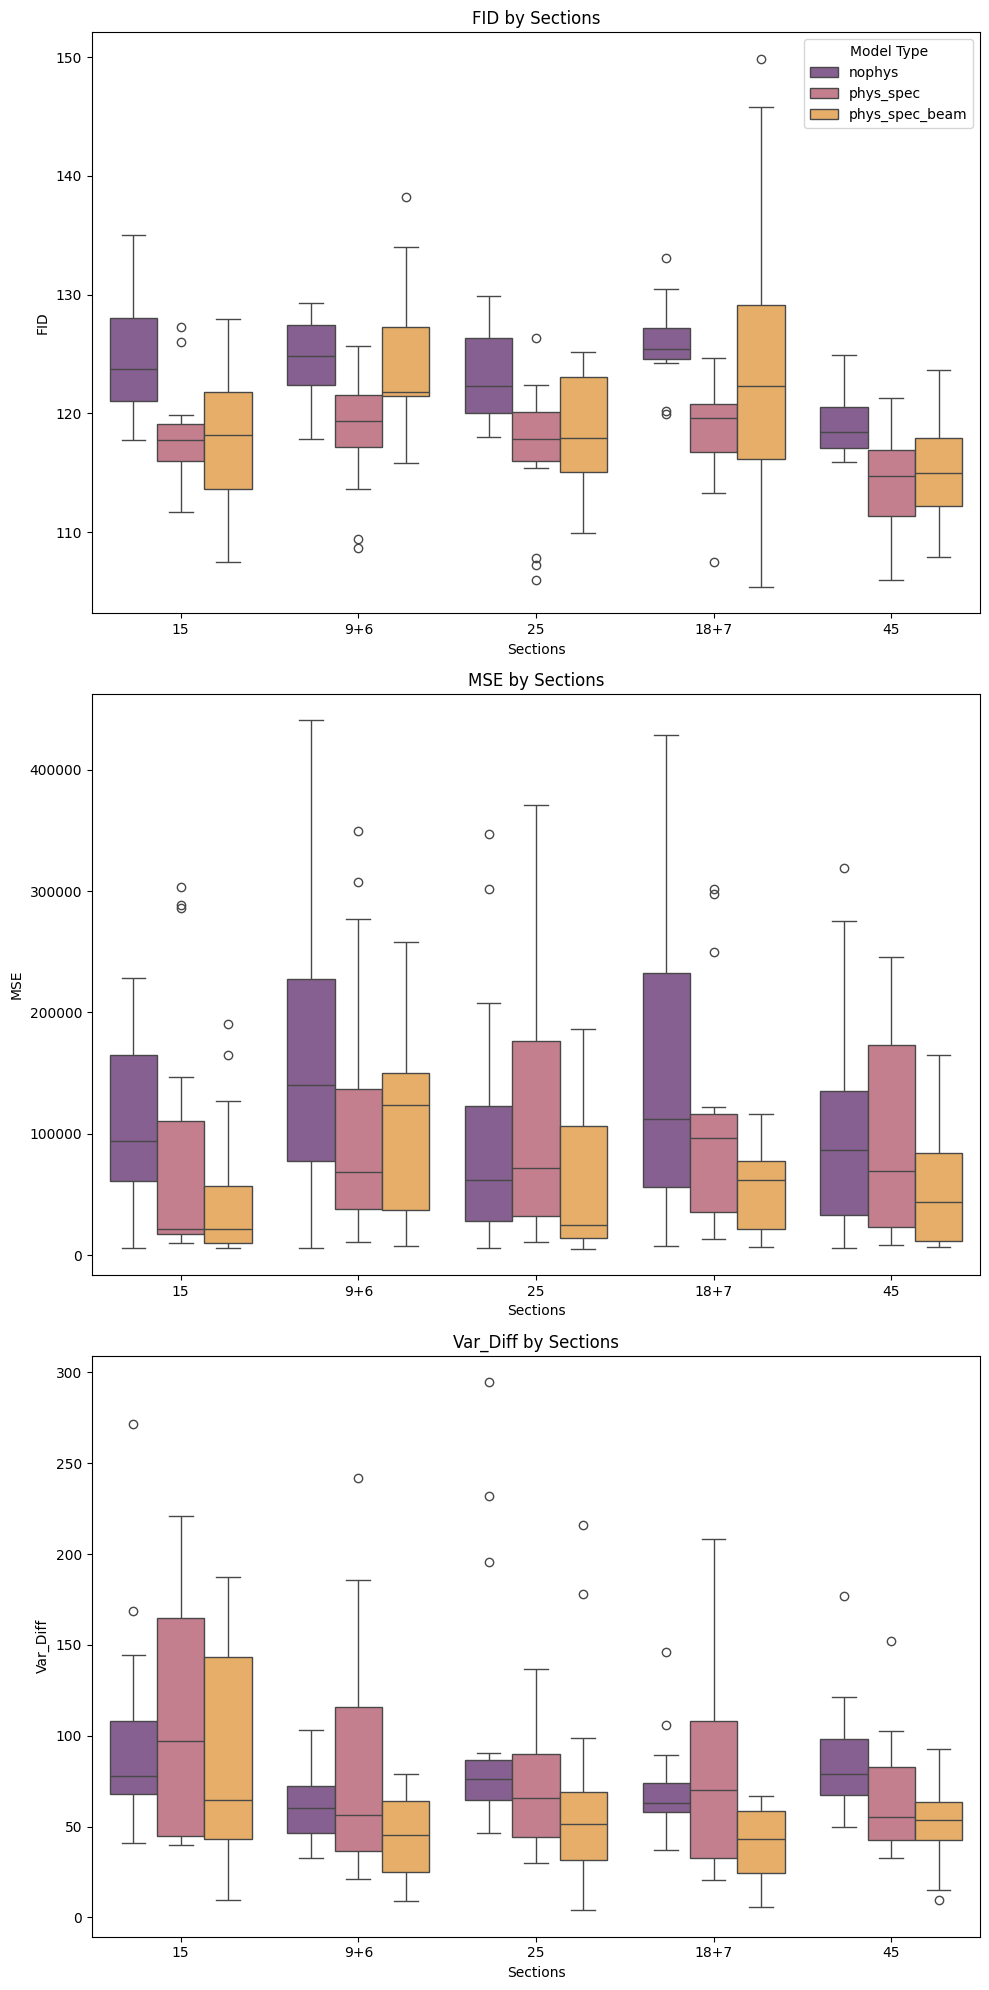

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load your data
data = pd.read_csv('combined.csv')

# Metrics for subcharts
metrics_subcharts = ['FID', 'MSE', 'Var_Diff']

def to_pastel(color, weight=0.3):
    """ Blend color with white to create a pastel shade """
    white = np.array([1, 1, 1])
    color = np.array(color)
    return list((1 - weight) * color + weight * white)
original_palette = sns.color_palette('inferno', n_colors=3)
pastel_palette = [to_pastel(color) for color in original_palette]

parameter = 'Sections'


fig, axes = plt.subplots(len(metrics_subcharts), 1, figsize=(10, 20))
for j, metric in enumerate(metrics_subcharts):
    sns.boxplot(ax=axes[j], x=parameter, y=metric, hue='Model Type', data=data, palette=pastel_palette)
    axes[j].set_title(f'{metric} by {parameter}')
    axes[j].set_xlabel(parameter)
    axes[j].set_ylabel(metric)
    if j != 0:  # Adjusting the condition to keep the legend in the first subplot
        axes[j].get_legend().remove()
    else:
        axes[j].legend(title='Model Type')

plt.tight_layout()
plt.savefig(f'{parameter}_metrics.png')  # Save the figure after displaying
plt.show()
plt.close()
